# PROJECT TITLE: CLASSIFICATION AND RISK ANALYSIS OF LOANS

Importing the libraries that shall be used for this project. This is an active snippet and shall be updated through the course of *work*

In [175]:
import re
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# "magic" command to make plots show up in the notebook
%matplotlib inline 
mpl.style.use('ggplot')
sns.set(style='whitegrid')

from sklearn.preprocessing import OneHotEncoder #importing One hot encoder 
from sklearn.preprocessing import Normalizer #importing the appropriate scaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer as CT 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_absolute_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

Loading the actual data set into a pandas dataframe for analysis

In [2]:
#acc_df = pd.read_csv("/content/accepted_2007_to_2018Q4.csv",low_memory = False,) #path to use when working with Google colab; comment it out when working on Jupyter
acc_df = pd.read_csv('D:/NEU/Assignments/SML/Project/data/accepted/accepted_2007_to_2018Q4.csv', low_memory = False)

## Exploratory Data Analysis

In [3]:
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


The over features are divided into 113 numeric and 38 categorical features

In [4]:
acc_df.head().T

,0,1,2,3,4
id,68407277,68355089,68341763,66310712,68476807
member_id,NaN,NaN,NaN,NaN,NaN
loan_amnt,3600,24700,20000,35000,10400
funded_amnt,3600,24700,20000,35000,10400
funded_amnt_inv,3600,24700,20000,35000,10400
...,...,...,...,...,...
settlement_status,NaN,NaN,NaN,NaN,NaN
settlement_date,NaN,NaN,NaN,NaN,NaN
settlement_amount,NaN,NaN,NaN,NaN,NaN
settlement_percentage,NaN,NaN,NaN,NaN,NaN


In [5]:
acc_df.tail().T

,2260696,2260697,2260698,2260699,2260700
id,88985880,88224441,88215728,Total amount funded in policy code 1: 1465324575,Total amount funded in policy code 2: 521953170
member_id,NaN,NaN,NaN,NaN,NaN
loan_amnt,40000,24000,14000,NaN,NaN
funded_amnt,40000,24000,14000,NaN,NaN
funded_amnt_inv,40000,24000,14000,NaN,NaN
...,...,...,...,...,...
settlement_status,NaN,ACTIVE,NaN,NaN,NaN
settlement_date,NaN,Mar-2019,NaN,NaN,NaN
settlement_amount,NaN,10000,NaN,NaN,NaN
settlement_percentage,NaN,44.82,NaN,NaN,NaN


Checking the Null values in each feature as a fraction.

In [6]:
missing_fractions = acc_df.isnull().mean().sort_values(ascending=False)
missing_fractions.head(15)

member_id                                     1.000000
orig_projected_additional_accrued_interest    0.996173
hardship_loan_status                          0.995171
hardship_dpd                                  0.995171
hardship_reason                               0.995171
hardship_status                               0.995171
deferral_term                                 0.995171
hardship_amount                               0.995171
hardship_start_date                           0.995171
hardship_end_date                             0.995171
payment_plan_start_date                       0.995171
hardship_length                               0.995171
hardship_type                                 0.995171
hardship_payoff_balance_amount                0.995171
hardship_last_payment_amount                  0.995171
dtype: float64

In [7]:
acc_df.shape

(2260701, 151)

The actual dataframe consists of a total of over 2.2 million rows categorized into 151 features. Some of these features are not available to the investors before issuing the loan and therefore should be dropped. The features available to investors are given in a data dictionary (Excel file) provided by Lending Club.

In [8]:
raw_data=acc_df

In [9]:
#meta_data = pd.read_excel("/content/LCDataDictionary.xlsx", sheet_name = 'browseNotes') #path to use when working with Google colab; comment it out when working on Jupyter
meta_data = pd.read_excel("D:/NEU/Assignments/SML/Project/data/LCDataDictionary.xlsx", sheet_name = 'browseNotes')
print(meta_data.shape)
meta_data.head()

(122, 2)


,BrowseNotesFile,Description
0,acceptD,The date which the borrower accepted the offer
1,accNowDelinq,The number of accounts on which the borrower i...
2,accOpenPast24Mths,Number of trades opened in past 24 months.
3,addrState,The state provided by the borrower in the loan...
4,all_util,Balance to credit limit on all trades


There are a total of 122 features of interest out of the 151 attributes in the original dataset which are available to the investors at the time of giving out a loan.

In [10]:

raw_data.columns = raw_data.columns.str.lower() # Converting the column names to all lower case
def col_match(raw_data, meta_data):
  ''' this function takes in a dataframe and a metadata associated with it and matches the column names in the dataframe to it's name present in the metadata file.
   After the matching is done, it returns the matching column names'''
   
  met_col_arr = meta_data['BrowseNotesFile'].dropna().values #adding the feature names in metadata as a list
  met_col_lower = list(map(lambda x: x.lower().strip(), met_col_arr)) #converting all the feature names in metadata into lowercases and storing them in a list
    
  #Doing the same for the column names of the raw_data
  raw_data_col = list(raw_data.columns.values)
  raw_col_lower = list(map(lambda x: x.lower().strip(), raw_data_col))
    
  #even after converting to lower case, there are still some mismatches due to spelling differences in the two files
  #This has to be manually changed in either of the two files to find the right meaningful matches
  match_cols = list(np.intersect1d(raw_col_lower, met_col_lower))
  return np.array((match_cols, raw_col_lower, met_col_lower))

In [11]:
match_cols = col_match(raw_data, meta_data)[0]
len(match_cols)

71

71 features found a direct match in both the files. These shall be retained in addition to some others that are common but misspelled in either of the files


In [12]:
#Manual work to rename the column name in either of the files
raw_col_lower = col_match(raw_data, meta_data)[1]
met_col_lower = col_match(raw_data, meta_data)[2]

In [13]:
np.setdiff1d(raw_col_lower, met_col_lower)

array(['acc_now_delinq', 'acc_open_past_24mths', 'addr_state',
       'annual_inc', 'bc_open_to_buy', 'bc_util',
       'collection_recovery_fee', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'deferral_term', 'delinq_2yrs',
       'delinq_amnt', 'earliest_cr_line', 'emp_length', 'fico_range_high',
       'fico_range_low', 'funded_amnt', 'funded_amnt_inv',
       'hardship_amount', 'hardship_dpd', 'hardship_end_date',
       'hardship_flag', 'hardship_last_payment_amount', 'hardship_length',
       'hardship_loan_status', 'hardship_payoff_balance_amount',
       'hardship_reason', 'hardship_start_date', 'hardship_status',
       'hardship_type', 'home_ownership', 'initial_list_status',
       'inq_last_6mths', 'int_rate', 'issue_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt',
       'last_pymnt_d', 'loan_amnt', 'loan_status', 'member_id',
       'mo_sin_old_il_acct', 'mort_acc', 'mths_since_last_delinq',
       'mths_sinc

In [14]:
np.setdiff1d(met_col_lower, raw_col_lower)

array(['acceptd', 'accnowdelinq', 'accopenpast24mths', 'addrstate',
       'annualinc', 'bcopentobuy', 'bcutil', 'creditpulld', 'delinq2yrs',
       'delinqamnt', 'earliestcrline', 'effective_int_rate', 'emplength',
       'expd', 'expdefaultrate', 'ficorangehigh', 'ficorangelow',
       'fundedamnt', 'homeownership', 'ils_exp_d', 'initialliststatus',
       'inqlast6mths', 'intrate', 'isincv', 'listd', 'loanamnt',
       'memberid', 'mortacc', 'msa', 'mths_since_oldest_il_open',
       'mthssincelastdelinq', 'mthssincelastrecord',
       'mthssincemostrecentinq', 'mthssincerecentbc',
       'mthssincerecentloandelinq', 'mthssincerecentrevoldelinq',
       'openacc', 'percentbcgt75', 'pubrec', 'reviewstatus',
       'reviewstatusd', 'revolbal', 'revolutil', 'servicefeerate',
       'subgrade', 'totalacc', 'totalbalexmort', 'totalbclimit',
       'verified_status_joint'], dtype='<U35')

In [15]:
right_cols = ['acc_now_delinq', 'acc_open_past_24mths', 'addr_state',
       'annual_inc', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs',
       'delinq_amnt', 'earliest_cr_line', 'emp_length',
       'fico_range_high', 'fico_range_low',
       'funded_amnt', 'home_ownership', 'initial_list_status',
       'inq_last_6mths', 'int_rate', 'last_credit_pull_d', 'loan_amnt',
       'member_id', 'mort_acc','mths_since_last_delinq',
       'mths_since_last_record', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'percent_bc_gt_75', 'pub_rec',
       'revol_bal', 'revol_util', 'sub_grade', 'total_acc', 
       'total_bal_ex_mort', 'total_bc_limit','verification_status_joint', 'issue_d', 'loan_status']


In [16]:
total_cols = match_cols + right_cols

53 Numeric variables + 16 categorical variables. 
Machine learnnig algorithms don't work well with the categorical features. We'll need to convert these categorical features into continuous values(using one hot encoder later), however this transformation can take a lot of time if there are many unique values in each category(true in our case). Also, such a feature(with more unique values) will not contribute much towards the hypothesis.  Hence, we'll be removing such categorical features from the feature space.

Checking the unique values for each coulmn in the dataframe. If the percentafe of unique values is greater than 30, we are going to drop those columns since they won't really add any value to the machine learning problem. 

In [17]:
data_colmatch = raw_data[total_cols].copy()

In [18]:
col_to_remove = []
for acol in data_colmatch.columns:
  if len(data_colmatch[acol].unique()) > data_colmatch.shape[0]*0.3:
    col_to_remove.append(acol)

col_to_remove

['id', 'url']

In [19]:
data_after_col_removal = data_colmatch.drop(col_to_remove, axis = 1)

In [20]:
data_without_null = data_after_col_removal
data_without_null_shape = data_without_null.shape

Finally we have the dataset with corresponding column matches in the data dictionary(meta data). The next step is to analyze this dataframe on a high level to understand parameters like mean, na values, etc

Using the describe function to get an overview of various attributes(mean, max, min and total count(excluding Nulls))

In [21]:
data_without_null.describe()

,all_util,annual_inc_joint,avg_cur_bal,chargeoff_within_12_mths,collections_12_mths_ex_med,dti,dti_joint,il_util,inq_fi,inq_last_12m,...,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,percent_bc_gt_75,pub_rec,revol_bal,revol_util,total_acc,total_bal_ex_mort,total_bc_limit
count,1.394320e+06,1.207100e+05,2.190322e+06,2.260523e+06,2.260523e+06,2.258957e+06,120706.000000,1.191818e+06,1.394539e+06,1.394538e+06,...,519701.000000,1.965233e+06,740359.000000,2.185289e+06,2.260639e+06,2.260668e+06,2.258866e+06,2.260639e+06,2.210638e+06,2.210638e+06
mean,5.703230e+01,1.236246e+05,1.354780e+04,8.464413e-03,1.814580e-02,1.882420e+01,19.251817,6.914098e+01,1.012867e+00,2.036667e+00,...,39.303090,7.024194e+00,35.782223,4.243513e+01,1.975278e-01,1.665846e+04,5.033770e+01,2.416255e+01,5.102294e+04,2.319377e+04
std,2.090475e+01,7.416135e+04,1.647408e+04,1.048098e-01,1.508131e-01,1.418333e+01,7.822086,2.374839e+01,1.489456e+00,2.383117e+00,...,22.617689,5.965411e+00,22.307239,3.621616e+01,5.705150e-01,2.294831e+04,2.471307e+01,1.198753e+01,4.991124e+04,2.300656e+04
min,0.000000e+00,5.693510e+03,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,4.300000e+01,8.340000e+04,3.080000e+03,0.000000e+00,0.000000e+00,1.189000e+01,13.530000,5.500000e+01,0.000000e+00,0.000000e+00,...,21.000000,2.000000e+00,17.000000,0.000000e+00,0.000000e+00,5.950000e+03,3.150000e+01,1.500000e+01,2.089200e+04,8.300000e+03
50%,5.800000e+01,1.100000e+05,7.335000e+03,0.000000e+00,0.000000e+00,1.784000e+01,18.840000,7.200000e+01,1.000000e+00,1.000000e+00,...,37.000000,5.000000e+00,33.000000,3.750000e+01,0.000000e+00,1.132400e+04,5.030000e+01,2.200000e+01,3.786400e+04,1.630000e+04
75%,7.200000e+01,1.479950e+05,1.878300e+04,0.000000e+00,0.000000e+00,2.449000e+01,24.620000,8.600000e+01,1.000000e+00,3.000000e+00,...,57.000000,1.100000e+01,51.000000,7.140000e+01,0.000000e+00,2.024600e+04,6.940000e+01,3.100000e+01,6.435000e+04,3.030000e+04
max,2.390000e+02,7.874821e+06,9.580840e+05,1.000000e+01,2.000000e+01,9.990000e+02,69.490000,1.000000e+03,4.800000e+01,6.700000e+01,...,202.000000,2.500000e+01,202.000000,1.000000e+02,8.600000e+01,2.904836e+06,8.923000e+02,1.760000e+02,3.408095e+06,1.569000e+06


Checking the percent of null values for each feature to take futher decision whether to consider them for the analysis or not.

In [22]:
null_per_feature = (data_without_null.isnull().sum()/data_without_null_shape[0]) * 100
null_per_feature

all_util                     38.323555
annual_inc_joint             94.660506
application_type              0.001460
avg_cur_bal                   3.113149
chargeoff_within_12_mths      0.007874
                               ...    
total_bal_ex_mort             2.214490
total_bc_limit                2.214490
verification_status_joint    94.880791
issue_d                       0.001460
loan_status                   0.001460
Length: 107, dtype: float64

Some of the features have a very high number of null values in terms of percentages. Dropping the features with over 30% nulls as they cannot be imputed.

In [23]:
data_without_null = data_without_null[data_without_null.columns[data_without_null.isnull().mean() < 0.3]]
data_without_null.shape

(2260701, 70)

In [24]:
data_without_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 70 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   application_type            object 
 1   avg_cur_bal                 float64
 2   chargeoff_within_12_mths    float64
 3   collections_12_mths_ex_med  float64
 4   disbursement_method         object 
 5   dti                         float64
 6   emp_title                   object 
 7   grade                       object 
 8   installment                 float64
 9   mo_sin_old_rev_tl_op        float64
 10  mo_sin_rcnt_rev_tl_op       float64
 11  mo_sin_rcnt_tl              float64
 12  num_accts_ever_120_pd       float64
 13  num_actv_bc_tl              float64
 14  num_actv_rev_tl             float64
 15  num_bc_sats                 float64
 16  num_bc_tl                   float64
 17  num_il_tl                   float64
 18  num_op_rev_tl               float64
 19  num_rev_accts        

## Data Visualisations and EDA:  

Checking the loan repayment status for the entire data file(category vs count)

In [25]:
data_for_eda_viz = data_without_null

In [26]:
loan_status_values = pd.DataFrame(data_for_eda_viz['loan_status'].value_counts())
loan_status_values

,loan_status
Fully Paid,1076751
Current,878317
Charged Off,268559
Late (31-120 days),21467
In Grace Period,8436
Late (16-30 days),4349
Does not meet the credit policy. Status:Fully Paid,1988
Does not meet the credit policy. Status:Charged Off,761
Default,40


Text(0, 0.5, 'Total Count')

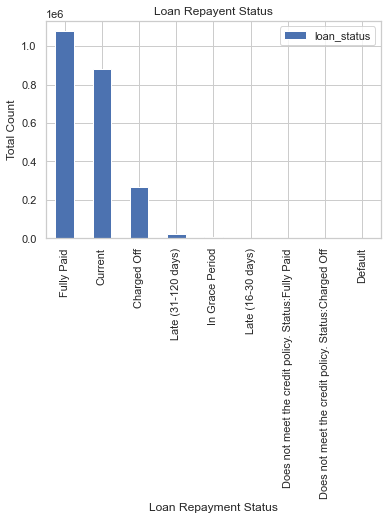

In [27]:
loan_status_values.plot.bar()
plt.title("Loan Repayent Status")
plt.xlabel("Loan Repayment Status")
plt.ylabel("Total Count")


From the plot it is clear that the three major categories of loans are Fully Paid, Current, and Charged Off. Since the outcome of 'Current' loans is still unknown we will use the other two classes (Fully Paid and Charged Off) for our project.

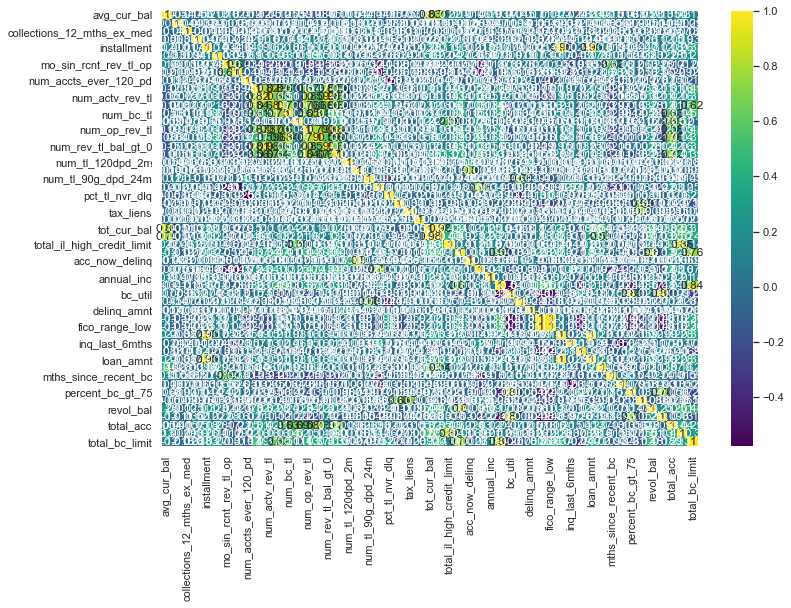

In [28]:
plt.figure(figsize=(12, 8))
sns.heatmap(data_for_eda_viz.corr(), annot=True, cmap='viridis')

In [29]:
#5 point summary of loan amount
data_for_eda_viz['loan_amnt'].describe()

count    2.260668e+06
mean     1.504693e+04
std      9.190245e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.290000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

Range of loan amount -> $500 - $40000

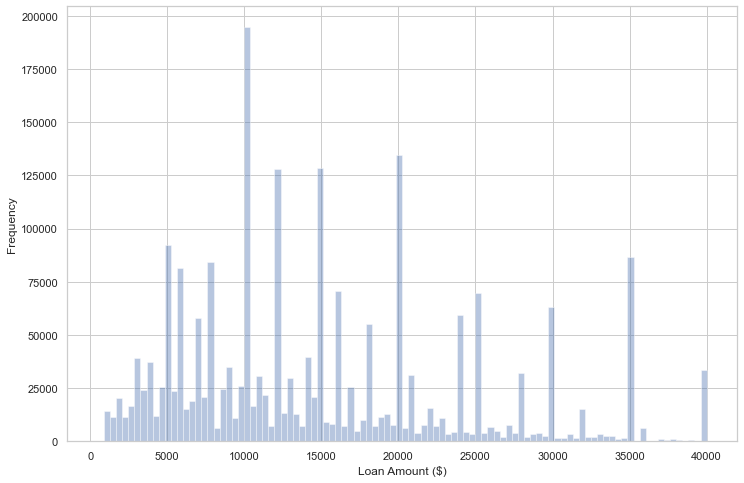

In [30]:
plt.figure(figsize=(12,8))
plt.ylabel('Frequency')
sns.distplot(data_for_eda_viz['loan_amnt'],bins=100,kde=False)
plt.xlabel('Loan Amount ($)')
plt.show()

In [31]:
data_for_eda_viz.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,15565.055444,8814.560077,900.0,9000.0,14350.0,20400.0,40000.0
Current,878317.0,15942.815920,9771.679047,1000.0,8400.0,14000.0,21500.0,40000.0
Default,40.0,14350.625000,10323.789256,1675.0,5875.0,10475.0,20000.0,40000.0
Does not meet the credit policy. Status:Charged Off,761.0,9527.233903,6404.598723,500.0,5000.0,7750.0,12000.0,25000.0
Does not meet the credit policy. Status:Fully Paid,1988.0,8853.231891,6163.442950,500.0,4000.0,7200.0,12000.0,25000.0
Fully Paid,1076751.0,14134.369808,8669.028973,500.0,7500.0,12000.0,20000.0,40000.0
In Grace Period,8436.0,17672.558084,9750.247681,1000.0,10000.0,16000.0,24600.0,40000.0
Late (16-30 days),4349.0,17391.118648,9987.086894,1000.0,10000.0,15000.0,24800.0,40000.0
Late (31-120 days),21467.0,16946.614571,9665.983393,1000.0,10000.0,15000.0,24000.0,40000.0


Charged-off loans tend to have higher loan amounts.

In [32]:
data_for_eda_viz['term'].value_counts(dropna=False)

 36 months    1609754
 60 months     650914
NaN                33
Name: term, dtype: int64

In [33]:
data_for_eda_viz['int_rate'].describe()

count    2.260668e+06
mean     1.309283e+01
std      4.832138e+00
min      5.310000e+00
25%      9.490000e+00
50%      1.262000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

Range of Interest Rate -> 5.31% - 30.99%

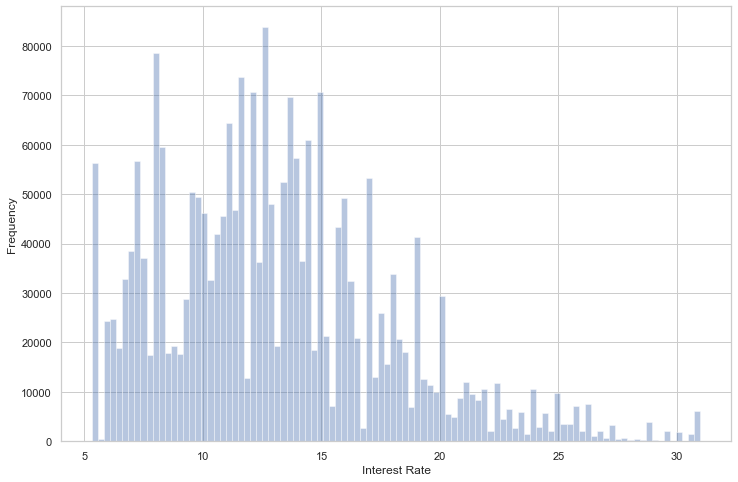

In [34]:
plt.figure(figsize=(12,8))
plt.ylabel('Frequency')
sns.distplot(data_for_eda_viz['int_rate'],bins=100,kde=False)
plt.xlabel('Interest Rate')
plt.show()

In [35]:
data_for_eda_viz.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,15.710714,4.910387,5.31,12.2900,15.05,18.5500,30.99
Current,878317.0,12.768128,4.874868,5.31,9.4300,11.99,15.3100,30.99
Default,40.0,16.181750,6.009668,5.32,11.8600,16.73,19.2725,30.74
Does not meet the credit policy. Status:Charged Off,761.0,14.597148,2.664766,7.43,12.8700,14.50,16.3200,21.64
Does not meet the credit policy. Status:Fully Paid,1988.0,13.978642,2.732150,6.00,12.3975,13.98,15.6800,21.64
Fully Paid,1076751.0,12.623288,4.527227,5.31,9.1700,12.23,15.3100,30.99
In Grace Period,8436.0,15.461246,5.248388,5.31,11.5500,14.99,18.4500,30.99
Late (16-30 days),4349.0,15.411380,5.336441,5.31,11.4900,14.52,18.4500,30.99
Late (31-120 days),21467.0,15.637190,5.317858,5.31,11.9800,14.99,18.9400,30.99


We can see that Charged off loans have higher interest rates as compared to Fully Paid loans.

Intuition - High risk individuals are given loans at high interest. If we are able to calculate the 'high risk' and predict that these loans would be Fully paid, we will be looking at a high profit.

In [36]:
print(data_for_eda_viz['grade'].unique())

['C' 'B' 'F' 'A' 'E' 'D' 'G' nan]


In [37]:
print(data_for_eda_viz['sub_grade'].unique())

['C4' 'C1' 'B4' 'C5' 'F1' 'C3' 'B2' 'B1' 'A2' 'B5' 'C2' 'E2' 'A4' 'E3'
 'A1' 'D4' 'F3' 'D1' 'B3' 'E4' 'D3' 'D2' 'D5' 'A5' 'F2' 'E1' 'F5' 'E5'
 'A3' 'G2' 'G1' 'G3' 'G4' 'F4' 'G5' nan]


In [39]:
data_for_eda_viz.shape

(2260701, 70)

In [40]:
data_for_eda_viz1 = data_for_eda_viz

In [41]:
data_for_eda_viz1 = data_for_eda_viz1.dropna()

In [42]:
data_for_eda_viz1.shape

(1694855, 70)

In [43]:
print(sorted(data_for_eda_viz1['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [44]:
print(sorted(data_for_eda_viz1['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


In [45]:
from statsmodels.graphics.mosaicplot import mosaic


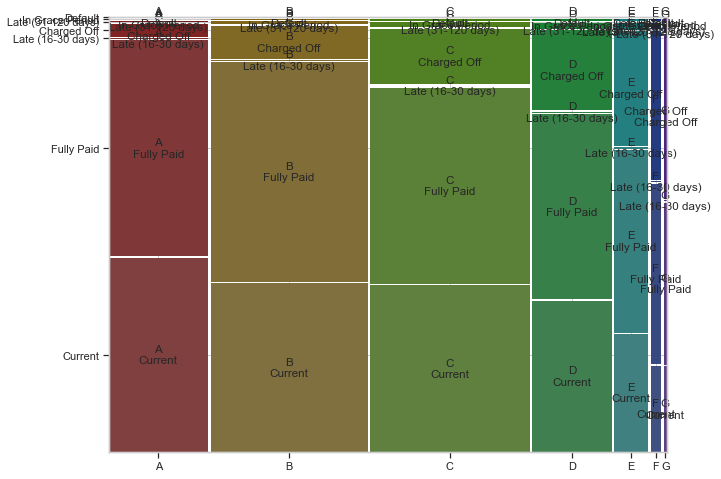

In [46]:
plt.rcParams['font.size'] = 14.0
fig, ax = plt.subplots(figsize=(10, 8))
mosaic(data_for_eda_viz1.sort_values('grade'), ['grade', 'loan_status'], gap=0.005 , ax=ax);

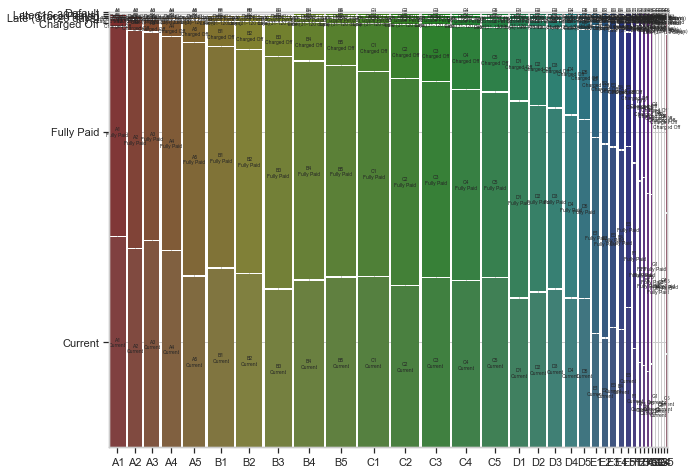

In [47]:
plt.rcParams['font.size'] = 6.0
fig, ax = plt.subplots(figsize=(10, 8))
mosaic(data_for_eda_viz1.sort_values('sub_grade'), ['sub_grade', 'loan_status'], gap=0.005 , ax=ax);

We can drop the grade column as the 'sub_grade' provides us with more information and implies 'grade'.

In [48]:
data_for_eda_viz1 = data_for_eda_viz1.drop('grade', axis = 1)
data_for_eda_viz1 = data_for_eda_viz1.drop('sub_grade', axis = 1)

In [49]:
data_for_eda_viz1.shape

(1694855, 68)

Dropping the rows with loan status other than 'Fully Paid' and 'Charged Off' and 'default'

In [50]:
#df_new = df[df['Pid'] == 'p01']
fully_paid_ev = data_for_eda_viz1[(data_for_eda_viz1['loan_status'] == 'Fully Paid') |
                                  (data_for_eda_viz1['loan_status'] == 'Charged Off')] #|
                                  #(data_for_eda_viz1['loan_status'] == 'Default')]
                                  

In [51]:
print(fully_paid_ev['loan_status'].unique())

['Fully Paid' 'Charged Off']


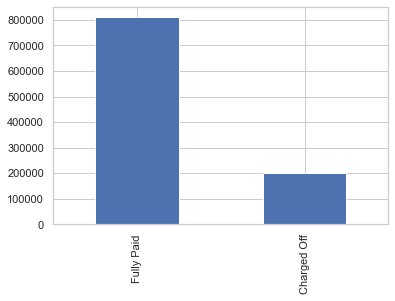

In [52]:
fully_paid_ev['loan_status'].value_counts().plot(kind='bar')

We can clearly see that the chances of loan being 'Charged Off' increases as the grade deacreases.

In [53]:
data_for_eda_viz1['home_ownership'].value_counts()

MORTGAGE    863048
RENT        653064
OWN         178053
ANY            621
OTHER           36
NONE            33
Name: home_ownership, dtype: int64

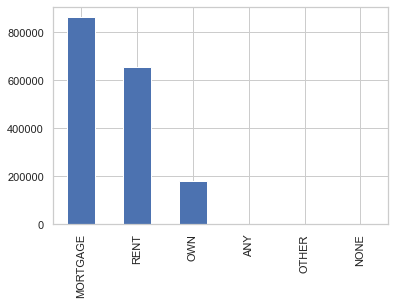

In [54]:
data_for_eda_viz1['home_ownership'].value_counts().plot.bar()

We can change the categories of Any, Other, and None to just one category - Other.

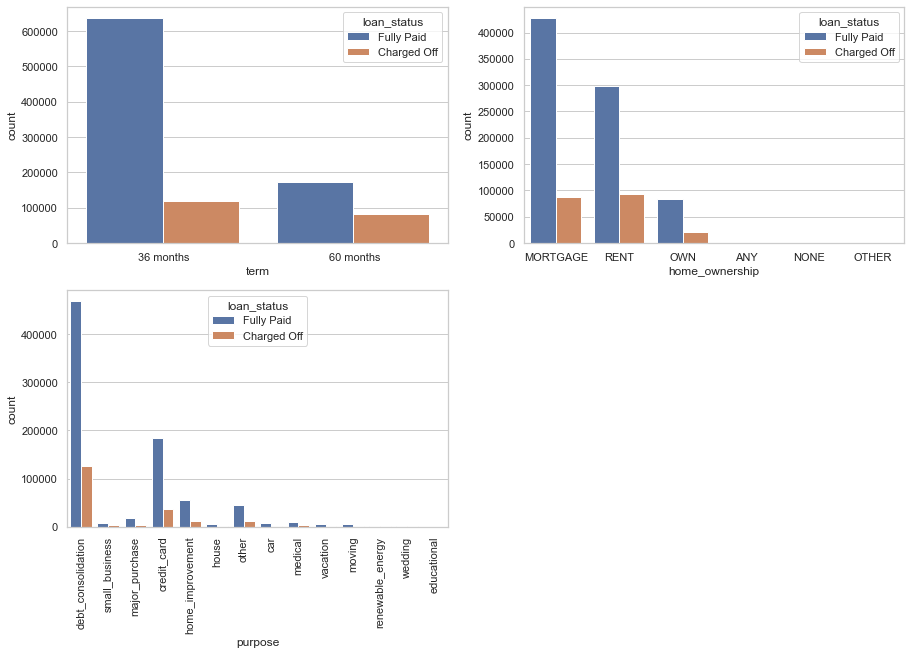

In [55]:
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=fully_paid_ev, hue='loan_status')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=fully_paid_ev, hue='loan_status')

#plt.subplot(4, 2, 3)
#sns.countplot(x='int_rate', data=fully_paid_ev, hue='loan_status')

plt.subplot(4, 2, 3)
g = sns.countplot(x='purpose', data=fully_paid_ev, hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [56]:
fully_paid_ev.title.isna().sum()

0

In [57]:
fully_paid_ev.title.str.lower().value_counts()[:10]

debt consolidation         542038
credit card refinancing    197215
home improvement            62141
other                       52074
major purchase              19606
medical expenses            10551
business                     9486
car financing                8991
vacation                     6384
moving and relocation        6247
Name: title, dtype: int64

## Data Transformation

In [321]:
data_for_tansformation = fully_paid_ev

In [322]:
data_for_tansformation['issue_d']= list(map(lambda x: int(x.split('-')[1]), data_for_tansformation['issue_d']))

AttributeError: 'int' object has no attribute 'split'

In [323]:
data_after_2015 = data_for_tansformation[data_for_tansformation.issue_d > 2015]

In [324]:
data_after_2015.shape

(398865, 68)

Splitting the data into feature set 'features' and target variable 'target'(loan_status)

In [325]:
features = data_after_2015.iloc[ : , :-1]
target = data_after_2015.iloc[ :  , -1]


The next step is to convert all the categorical variable in the features to one hot encoding since the machine learning models that shall be used later work better with continuous feature variables. Also, all the features need to be scaled since most of the algorithms work well with scaled data in each dimension. 

The two operations can be simultaneouly done using column transformer from sklearn. It can apply one hot encoding to the categorical variables and scale the continuous variables as well. 

In addition, we shall be imputing the Null values (median for numeric and mode for the catagorical features) since the tranformers will not work with the missing values.

In [326]:
cat_features = list(features.select_dtypes(include = object).columns)
cont_features = list(features.select_dtypes(include = float).columns)


In [327]:
for i in range(len(cat_features)):
  print(i, len(features[cat_features].iloc[ : , i].unique()))

0 2
1 2
2 115133
3 13
4 2
5 13
6 908
7 50
8 672
9 11
10 5
11 2
12 41


The 3'rd column in the categorical features has a high proportion of unique values and hence we are dropping this column from the dataset since the encoing takes a very high amount of time. 

In [328]:
del(cat_features[2])

In [329]:
num_tansformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', Normalizer())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = CT(transformers = [('cont', num_tansformer, cont_features),('cat', cat_transformer, cat_features)])


In [ ]:
#transformed_features = preprocessor.fit_transform(features)
#transformed_features.shape

The next step is to check the features that are relevant to the classification problem. Checking the corelation between the features[in data visualization] didn't prove to be effective since the number of features is still relatively high. 

Another method is to use Recursive Feature Elimination(RFE from Scikit Lean) to eliminate some of the features which do have a high impact on the target variable. 

In [68]:
rfc = RandomForestClassifier()

<bound method NDFrame.head of 421101     1
421113     1
421120     1
421135     1
421137     1
          ..
2260686    1
2260690    1
2260691    0
2260692    1
2260697    0
Name: loan_status, Length: 398865, dtype: object>

## Fitting Machine Learning Models

In [85]:
X = transformed_features
y = target

Splitting the dataset into test, train, and valid. Since we have fairly Ratio - 70/15/15 ratio. 

In [107]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y , train_size = 0.7, random_state = 10)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [108]:
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

*Decsion Tree Classifier*  

In [109]:
clf_dt = DecisionTreeClassifier()

In [110]:
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [111]:
y_pred_dt = clf_dt.predict(X_valid)

In [113]:

print('Accuracy of the decision tree model on the training set:\n', accuracy_score(y_valid, y_pred_dt))


print('Recall score of the decision tree model on the training set:\n', recall_score(y_valid, y_pred_dt, average="binary", pos_label='Fully Paid'))
print('Precision score of the decision tree model on the training set:\n', precision_score(y_valid, y_pred_dt, average="binary", pos_label='Fully Paid'))

Accuracy of the decision tree model on the training set:
 0.7114658198228313
Recall score of the decision tree model on the training set:
 0.8228947647870872
Precision score of the decision tree model on the training set:
 0.812796307950493


*Logistic Regression(L2 Regularization)* 

In [114]:
log_reg = LogisticRegression(penalty = 'l2')

In [115]:
log_reg.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [116]:
y_pred_log = log_reg.predict(X_valid)
print('Accuracy of the logistic regression model on the training set:\n', accuracy_score(y_valid, y_pred_log))
print('Recall score of the logistic regression model on the training set:\n', recall_score(y_valid, y_pred_log, average="binary", pos_label='Fully Paid'))
print('Precision score of the logistic regression model on the training set:\n', precision_score(y_valid, y_pred_log, average="binary", pos_label='Fully Paid'))

Accuracy of the logistic regression model on the training set:
 0.790406150760488
Recall score of the logistic regression model on the training set:
 0.9747690347244345
Precision score of the logistic regression model on the training set:
 0.8017083267830005


*Random Forest Classifier*

In [117]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [118]:
rfc.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [119]:
y_pred_rfc = rfc.predict(X_valid)
print('Accuracy of the random forest classifier on the training set:\n', accuracy_score(y_valid, y_pred_rfc))
print('Recall score of the random forest classifier on the training set:\n', recall_score(y_valid, y_pred_rfc, average="binary", pos_label='Fully Paid'))
print('Precision score of the random forest classifier on the training set:\n', precision_score(y_valid, y_pred_rfc, average="binary", pos_label='Fully Paid'))

Accuracy of the random forest classifier on the training set:
 0.7737589837873976
Recall score of the random forest classifier on the training set:
 0.9363066794095785
Precision score of the random forest classifier on the training set:
 0.8070959119784706


*XGBoost*

In [120]:
from xgboost import XGBClassifier
import xgboost as xgb


In [141]:
y_xgb = y

In [142]:
y_xgb.head

<bound method NDFrame.head of 421101     1
421113     1
421120     1
421135     1
421137     1
          ..
2260686    1
2260690    1
2260691    0
2260692    1
2260697    0
Name: loan_status, Length: 398865, dtype: object>

In [143]:
y_xgb[y_xgb == 'Fully Paid'] = 1
y_xgb[y_xgb == 'Charged Off'] = 0

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [155]:
y_xgb = y_xgb.astype(str).astype(int)

In [156]:
data_dmatrix = xgb.DMatrix(data=X,label=y_xgb)

In [157]:
X_train_xgb, X_rem_xgb, y_train_xgb, y_rem_xgb = train_test_split(X, y_xgb , train_size = 0.7, random_state = 10)

In [158]:
X_valid_xgb, X_test_xgb, y_valid_xgb, y_test_xgb = train_test_split(X_rem_xgb,y_rem_xgb, test_size=0.5)

In [159]:
# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }         
           
          
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)


In [160]:
xgb_clf.fit(X_train_xgb, y_train_xgb)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=1.0,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

We can view the parameters of the xgb trained model above


In [162]:
y_pred_xgb = xgb_clf.predict(X_valid_xgb)
print('Accuracy of the XGBoost Classifier on the test set:\n', accuracy_score(y_valid_xgb, y_pred_xgb))
print('Recall score of the XGBoost Classifier on the test set:\n', recall_score(y_valid_xgb, y_pred_xgb, average="binary"))
print('Precision score of the XGBoost Classifier on the test set:\n', precision_score(y_valid_xgb, y_pred_xgb, average="binary"))

Accuracy of the XGBoost Classifier on the test set:
 0.7905231489219455
Recall score of the XGBoost Classifier on the test set:
 0.9452200561845577
Precision score of the XGBoost Classifier on the test set:
 0.8168392400640023


Accuracy, Recall, and Precision are better for XGBoost so we select this algorithm to tune our hyper parameters.

In [232]:
#num_boost_round is also one more paramter that we are tuning
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}

In [283]:
params['eval_metric'] = "error"

In [230]:
num_boost_round = 50 #ideally we want this to be a very high number

In [208]:
dtrain = xgb.DMatrix(X_valid, label=y_valid)

In [260]:
y_test_binary =y_test

In [261]:
y_test_binary[y_test_binary == 'Fully Paid'] = 1
y_test_binary[y_test_binary == 'Charged Off'] = 0

In [262]:
dtest = xgb.DMatrix(X_test, label=y_test_binary)

### Hyper Parameter Tuning

1. num_boost_round

In [284]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=5
)

[0]	Test-error:0.225405
Will train until Test-error hasn't improved in 5 rounds.
[1]	Test-error:0.222414
[2]	Test-error:0.219489
[3]	Test-error:0.217734
[4]	Test-error:0.217048
[5]	Test-error:0.216881
[6]	Test-error:0.216664
[7]	Test-error:0.216213
[8]	Test-error:0.21541
[9]	Test-error:0.21521
[10]	Test-error:0.215226
[11]	Test-error:0.214942
[12]	Test-error:0.214658
[13]	Test-error:0.214725
[14]	Test-error:0.214391
[15]	Test-error:0.213655
[16]	Test-error:0.21399
[17]	Test-error:0.213555
[18]	Test-error:0.213522
[19]	Test-error:0.213538
[20]	Test-error:0.213522
[21]	Test-error:0.213522
[22]	Test-error:0.213555
[23]	Test-error:0.213421
[24]	Test-error:0.213288
[25]	Test-error:0.213555
[26]	Test-error:0.213354
[27]	Test-error:0.213388
[28]	Test-error:0.213772
[29]	Test-error:0.213756
Stopping. Best iteration:
[24]	Test-error:0.213288



In [285]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'error'},
    early_stopping_rounds=5
)
cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.193005,0.000644,0.223985,0.006196
1,0.182116,0.001446,0.220926,0.004077
2,0.179187,0.001599,0.217065,0.003975
3,0.177453,0.002026,0.215009,0.004113
4,0.175990,0.001251,0.213204,0.004055
5,0.173233,0.001753,0.212252,0.003856
6,0.171218,0.001249,0.211700,0.003529
7,0.169581,0.001619,0.211282,0.004183
8,0.168314,0.001385,0.210480,0.004212
9,0.166889,0.001366,0.209778,0.004190


In [286]:
cv_results['test-error-mean'].min()

0.2079558

2. max_depth & min_child_weight

In [289]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,11)
    for min_child_weight in range(5,7)
]

In [291]:
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'error'},
        early_stopping_rounds=5
    )
    
    mean_mae = cv_results['test-error-mean'].min()
    boost_rounds = cv_results['test-error-mean'].argmin()
    print("\ttest-error-mean {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)

CV with max_depth=9, min_child_weight=5
	test-error-mean 0.21041300000000002 for 18 rounds
CV with max_depth=9, min_child_weight=6
	test-error-mean 0.2079558 for 23 rounds
CV with max_depth=10, min_child_weight=5
	test-error-mean 0.2101788 for 20 rounds
CV with max_depth=10, min_child_weight=6
	test-error-mean 0.2098946 for 23 rounds


In [292]:
print("Best params: {}, {}, Error: {}".format(best_params[0], best_params[1], min_mae))

Best params: 9, 6, Error: 0.2079558


In [293]:
params['max_depth'] = 9
params['min_child_weight'] = 6

3. subsample & colsample_bytree

In [294]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,10)]
    for colsample in [i/10. for i in range(7,10)]
]

In [296]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'error'},
        early_stopping_rounds=5
    )
    # Update best score
    mean_mae = cv_results['test-error-mean'].min()
    boost_rounds = cv_results['test-error-mean'].argmin()
    print("\tTest-error-mean {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)

CV with subsample=0.9, colsample=0.9
	Test-error-mean 0.2089754 for 13 rounds
CV with subsample=0.9, colsample=0.8
	Test-error-mean 0.21001180000000003 for 16 rounds
CV with subsample=0.9, colsample=0.7
	Test-error-mean 0.20905900000000002 for 29 rounds
CV with subsample=0.8, colsample=0.9
	Test-error-mean 0.20859100000000003 for 22 rounds
CV with subsample=0.8, colsample=0.8
	Test-error-mean 0.2085076 for 17 rounds
CV with subsample=0.8, colsample=0.7
	Test-error-mean 0.2083236 for 22 rounds
CV with subsample=0.7, colsample=0.9
	Test-error-mean 0.2089588 for 25 rounds
CV with subsample=0.7, colsample=0.8
	Test-error-mean 0.21012879999999998 for 23 rounds
CV with subsample=0.7, colsample=0.7
	Test-error-mean 0.20924299999999998 for 17 rounds


In [297]:
print("Best params: {}, {}, test-error-mean: {}".format(best_params[0], best_params[1], min_mae))

Best params: 0.8, 0.7, test-error-mean: 0.2083236


In [298]:
params['subsample'] = 0.8
params['colsample_bytree'] = 0.7

4. eta

In [300]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,metrics=['error'],early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-error-mean'].min()
    boost_rounds = cv_results['test-error-mean'].argmin()
    print("\ttest-error-mean {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta

Wall time: 0 ns
CV with eta=0.3
Wall time: 1min 2s
	test-error-mean 0.2114992 for 20 rounds

CV with eta=0.2
Wall time: 1min 5s
	test-error-mean 0.2083236 for 22 rounds

CV with eta=0.1
Wall time: 2min 32s
	test-error-mean 0.20579979999999995 for 64 rounds

CV with eta=0.05
Wall time: 3min 1s
	test-error-mean 0.20613399999999998 for 77 rounds



In [301]:
print("Best params: {}, test-error-mean: {}".format(best_params, min_mae))

Best params: 0.1, test-error-mean: 0.20579979999999995


While 0.1 does gives us lowest test error, the training round increase from 22 to 64 rounds. Due to computation costs and limitations we have take it as 0.2.

In [302]:
params['eta'] = .1

Optimized Hyperparamteres =>

In [303]:
params
{'colsample_bytree': 0.7,
 'eta': 0.1,
 'eval_metric': 'error',
 'max_depth': 9,
 'min_child_weight': 6,
 'objective': 'logistic',
 'subsample': 0.8
}

{'colsample_bytree': 0.7,
 'eta': 0.1,
 'eval_metric': 'error',
 'max_depth': 9,
 'min_child_weight': 6,
 'objective': 'logistic',
 'subsample': 0.8}

In [304]:
doriginal = xgb.DMatrix(X_train, label=y_train)

In [305]:
model = xgb.train(
    params,
    doriginal,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=5
)

[0]	Test-error:0.21867
Will train until Test-error hasn't improved in 5 rounds.
[1]	Test-error:0.216162
[2]	Test-error:0.215009
[3]	Test-error:0.214859
[4]	Test-error:0.213655
[5]	Test-error:0.213405
[6]	Test-error:0.213271
[7]	Test-error:0.213505
[8]	Test-error:0.212653
[9]	Test-error:0.213054
[10]	Test-error:0.212853
[11]	Test-error:0.212669
[12]	Test-error:0.211817
[13]	Test-error:0.211817
[14]	Test-error:0.211917
[15]	Test-error:0.211817
[16]	Test-error:0.211315
[17]	Test-error:0.211299
[18]	Test-error:0.211282
[19]	Test-error:0.211065
[20]	Test-error:0.210764
[21]	Test-error:0.210496
[22]	Test-error:0.210413
[23]	Test-error:0.21053
[24]	Test-error:0.210329
[25]	Test-error:0.210212
[26]	Test-error:0.209962
[27]	Test-error:0.210012
[28]	Test-error:0.209544
[29]	Test-error:0.209594
[30]	Test-error:0.209343
[31]	Test-error:0.209176
[32]	Test-error:0.209109
[33]	Test-error:0.208858
[34]	Test-error:0.208808
[35]	Test-error:0.208959
[36]	Test-error:0.208725
[37]	Test-error:0.208507
[38]	

In [308]:
print("Best test-error-mean: {:.7f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best test-error-mean: 0.2065020 in 80 rounds


We got less error (0.2065020) than our original test error (0.2079558) which was expected. While this might not seem like a big difference, a small decrease in error would help us classify risky loans and has a potential to save a lot of money. 

Let's see if this new model works better on the test set.

Final Testing

In [309]:
model = xgb.train(
    params,
    dtest,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=5
)

[0]	Test-error:0.20478
Will train until Test-error hasn't improved in 5 rounds.
[1]	Test-error:0.196808
[2]	Test-error:0.191961
[3]	Test-error:0.192228
[4]	Test-error:0.191459
[5]	Test-error:0.18947
[6]	Test-error:0.189754
[7]	Test-error:0.187648
[8]	Test-error:0.18718
[9]	Test-error:0.185927
[10]	Test-error:0.185476
[11]	Test-error:0.18459
[12]	Test-error:0.183069
[13]	Test-error:0.181849
[14]	Test-error:0.18133
[15]	Test-error:0.180144
[16]	Test-error:0.179291
[17]	Test-error:0.178924
[18]	Test-error:0.178807
[19]	Test-error:0.178522
[20]	Test-error:0.17782
[21]	Test-error:0.176918
[22]	Test-error:0.176417
[23]	Test-error:0.176099
[24]	Test-error:0.175698
[25]	Test-error:0.174912
[26]	Test-error:0.173726
[27]	Test-error:0.173007
[28]	Test-error:0.172606
[29]	Test-error:0.172205
[30]	Test-error:0.171703
[31]	Test-error:0.17065
[32]	Test-error:0.169798
[33]	Test-error:0.169413
[34]	Test-error:0.168277
[35]	Test-error:0.167458
[36]	Test-error:0.166789
[37]	Test-error:0.166104
[38]	Test-

In [310]:
print("Best test-error-mean: {:.6f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best test-error-mean: 0.136386 in 99 rounds


We did get a very less error as compared to orginal error!!
0.136386 < 0.2079558.

In [311]:
y_test_binary = y_test_binary.astype(str).astype(int)

In [315]:
y_test.head

<bound method NDFrame.head of 1024842    1
507029     1
567531     1
1985071    1
655579     1
          ..
720210     1
488232     1
2032230    1
1018551    1
1505875    1
Name: loan_status, Length: 59830, dtype: object>